# **Recipe Reviews & User Feedback**

The data dictionary is availabvle here: https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset

#**BLUF**

Several models with AUC above 91%. A KNN model was developed with AUC mean of 0.925, mean recall of 0.919, and mean accuracy of 0.938. MLP model provided similar performance.

We did not test the possibility that outliers (that we deleted) may end up actually helping our model. We compared the result with and without balancing, and it didn’t really effect the accuracy.

KNN and MLP exhibit strong performance with high accuracy and balanced accuracy, effectively handling class imbalance. Decision Tree and Random Forest show lower performance, indicating challenges with imbalance. SVM and XG Boost's performance could benefit from hyperparameter tuning. Overall, KNN and MLP are recommended for robust classification. There's a very small difference between runing these two models when they are not balanced compared to when they are balanced.

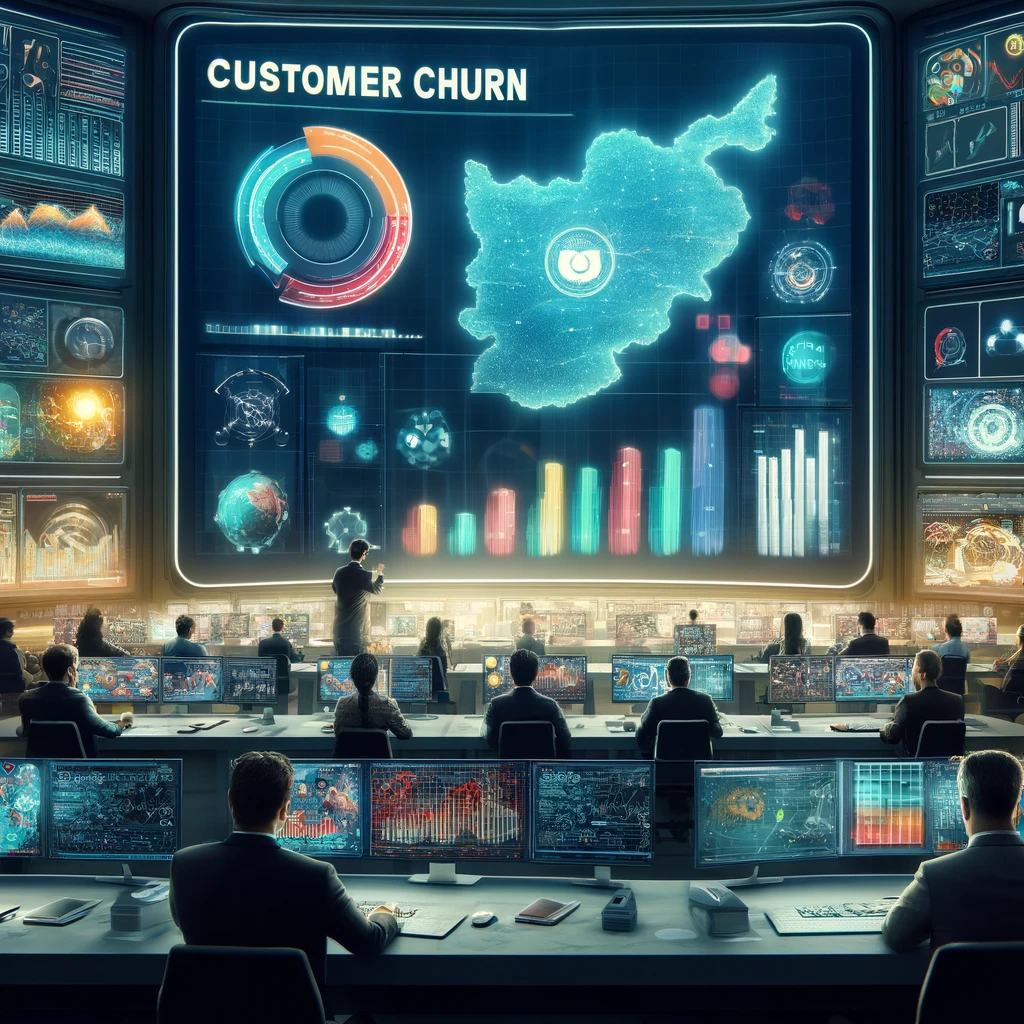

#**BLUF**

Wrtite your BLUF here!

In [1]:
!pip install ucimlrepo

In [15]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iranian_churn = fetch_ucirepo(id=563)

# data (as pandas dataframes)
X = iranian_churn.data.features
y = iranian_churn.data.targets

# Sample instances randomly
X_sampled = X.sample(n=100, random_state=42)
y_sampled = y.loc[X_sampled.index]  # Ensure targets match the sampled features

# metadata
print(iranian_churn.metadata)

# variable information
print(iranian_churn.variables)




{'uci_id': 563, 'name': 'Iranian Churn', 'repository_url': 'https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/563/data.csv', 'abstract': "This dataset is randomly collected from an Iranian telecom company's database over a period of 12 months.", 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 3150, 'num_features': 13, 'feature_types': ['Integer'], 'demographics': ['Age'], 'target_col': ['Churn'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C5JW3Z', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is randomly collected from an Iranian telecom companyâ€™s database over a period of 12 months. A total of 3150 rows of data, each representing a customer, bear information for 13 columns. The attribu

Selected features: Index(['Subscription  Length', 'Seconds of Use', 'Customer Value'], dtype='object')
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 59, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 118, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

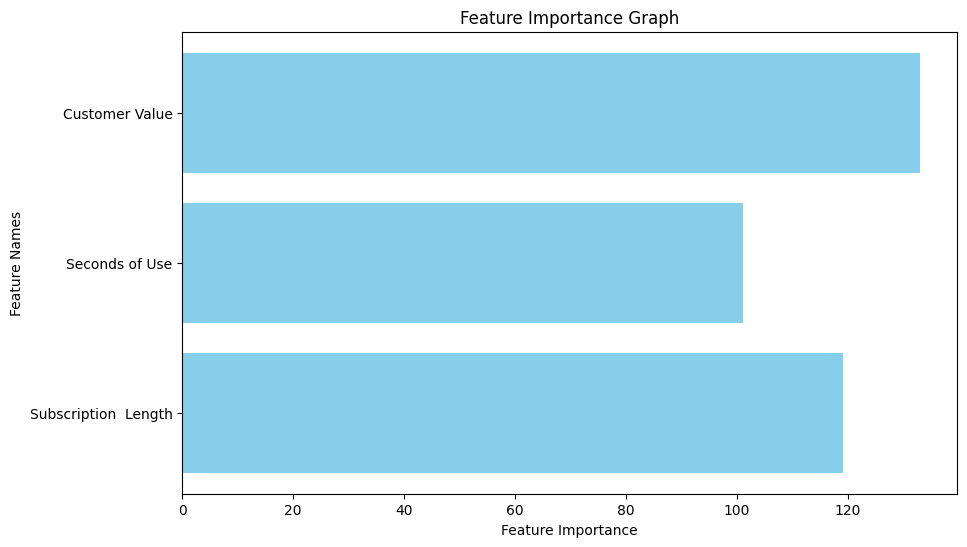

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[[16 11]
 [ 3  0]]
Accuracy: 0.5333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.59      0.70        27
           1       0.00      0.00      0.00         3

    accuracy                           0.53        30
   macro avg       0.42      0.30      0.35        30
weighted avg       0.76      0.53      0.63        30



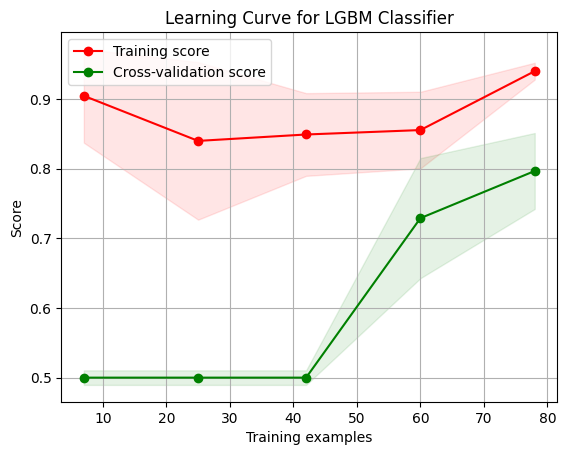

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Initialize the base classifier for RFE
base_estimator = RandomForestClassifier(random_state=42)

# RFE with Random Forest to find top features
selector = RFE(base_estimator, n_features_to_select=3, step=1)
X_reduced = selector.fit_transform(X_sampled, np.ravel(y_sampled))

# Get the names of the selected features
selected_features = X.columns[selector.support_]
print("Selected features:", selected_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_sampled, test_size=0.3, random_state=42)

# Apply SMOTE to overcome sample imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Setup the LGBMClassifier pipeline and grid search parameters
model = LGBMClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

%matplotlib inline
# Get feature importances
importances = best_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(selected_features, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance Graph")
plt.show()

# Learning Curve Function
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve
plot_learning_curve(grid_search.best_estimator_, 'Learning Curve for LGBM Classifier', X_train_smote, y_train_smote, cv=3)

# Predicting the Test set results and evaluating the model
y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


#**Metrics**

In [21]:
# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [22]:
# XGBoost
from xgboost import XGBClassifier

In [23]:
# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [24]:
# scikitplot
!pip install scikit-plot
import scikitplot as skplt

In [25]:

names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree", "Naive Bayes", "k Nearest Neighbors", "MLP", "Random Forest", "XG Boost"]
classifiers = [
    Perceptron(random_state=1),
    LogisticRegression(),
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(50,50),alpha=1, max_iter=1000),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3)]

# Build each classifier using the unbalanced TRAINING data, show decision region and petrformance of the unbalanced TEST data
no_folds = 5 # number of folds desired for cross validation
kf = StratifiedKFold(n_splits=no_folds, shuffle=True, random_state=12345)
for name, clf in zip(names, classifiers):
  print('CLASSIFIER: ',name,'\n')
  mean_accuracy = 0.0
  mean_balanced_accuracy = 0.0
  mean_auc = 0.0
  for fold, (train_index, test_index) in enumerate(kf.split(X,y),1):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
    stdsc = StandardScaler()
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
    X_test_std = stdsc.transform(X_test)
    clf.fit(X_train_SMOTE_std, y_train_SMOTE)
    y_pred = clf.predict(X_test_std)
    print(f'For fold {fold}:')
    print(f'Accuracy: {clf.score(X_test_std, y_test)}')
    print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}')
    print(f'AUC: {roc_auc_score(y_test, y_pred)}')
    mean_accuracy = mean_accuracy + clf.score(X_test_std, y_test)
    mean_balanced_accuracy = mean_balanced_accuracy + balanced_accuracy_score(y_test, y_pred)
    mean_auc = mean_auc + roc_auc_score(y_test, y_pred)
  mean_accuracy = mean_accuracy / no_folds
  mean_balanced_accuracy = mean_balanced_accuracy / no_folds
  mean_auc = mean_auc / no_folds
  print('Average accuracy: %.3f Average balanced accuracy: %.3f Average AUC: %.3f\n\n' % (mean_accuracy, mean_balanced_accuracy, mean_auc))

CLASSIFIER:  Perceptron 

For fold 1:
Accuracy: 0.7777777777777778
Balanced Accuracy: 0.8188666324259545
AUC: 0.8188666324259546
For fold 2:
Accuracy: 0.7984126984126985
Balanced Accuracy: 0.8598698852936142
AUC: 0.8598698852936142
For fold 3:
Accuracy: 0.8063492063492064
Balanced Accuracy: 0.852251326827598
AUC: 0.852251326827598
For fold 4:
Accuracy: 0.7682539682539683
Balanced Accuracy: 0.8091080294470125
AUC: 0.8091080294470125
For fold 5:
Accuracy: 0.7619047619047619
Balanced Accuracy: 0.7519260400616332
AUC: 0.7519260400616332
Average accuracy: 0.783 Average balanced accuracy: 0.818 Average AUC: 0.818


CLASSIFIER:  Logistic Regression 

For fold 1:
Accuracy: 0.8222222222222222
Balanced Accuracy: 0.8246875535011129
AUC: 0.8246875535011128
For fold 2:
Accuracy: 0.8222222222222222
Balanced Accuracy: 0.8534497517548365
AUC: 0.8534497517548365
For fold 3:
Accuracy: 0.8507936507936508
Balanced Accuracy: 0.8786166752268447
AUC: 0.8786166752268446
For fold 4:
Accuracy: 0.809523809523809

# The Best Model: KNN

In [28]:
model = imbpipeline([
        ('sample', SMOTE()),
        ('std', StandardScaler()),
        ('clf', KNeighborsClassifier())])

param_grid = {
    'clf__n_neighbors': range (1,10),
    'clf__weights': ['uniform', 'distance']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, scoring = 'roc_auc')
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_estimator_)

{'clf__n_neighbors': 8, 'clf__weights': 'uniform'}
Pipeline(steps=[('sample', SMOTE()), ('std', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=8))])


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=54321, stratify=y)

In [30]:
# SMOTE (oversampling)
# Data is unbalanced (38.54% converted instances)

import imblearn
print("imblearn version: ", imblearn.__version__)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12346)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

print("Shape before SMOTE: ", X_train.shape, y_train.shape, "\n")
print("Shape after SMOTE: ", X_train_SMOTE.shape, y_train_SMOTE.shape, "\n")

imblearn version:  0.10.1
Shape before SMOTE:  (2362, 13) (2362, 1) 

Shape after SMOTE:  (3982, 13) (3982, 1) 



In [31]:
# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
X_test_std = stdsc.transform(X_test)

In [38]:
# Fit best KNN model, predict test data
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_SMOTE_std,y_train_SMOTE)
y_pred = clf.predict(X_test_std)
print(f'AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Accuracy: {clf.score(X_test_std, y_test)}')

AUC: 0.9272979012825495
Accuracy: 0.932741116751269


In [39]:
# Reporting
print(confusion_matrix(y_test, y_pred))
print("Accuracy = ",accuracy_score(y_test, y_pred))
print("Recall = ",recall_score(y_test, y_pred))

[[621  43]
 [ 10 114]]
Accuracy =  0.932741116751269
Recall =  0.9193548387096774


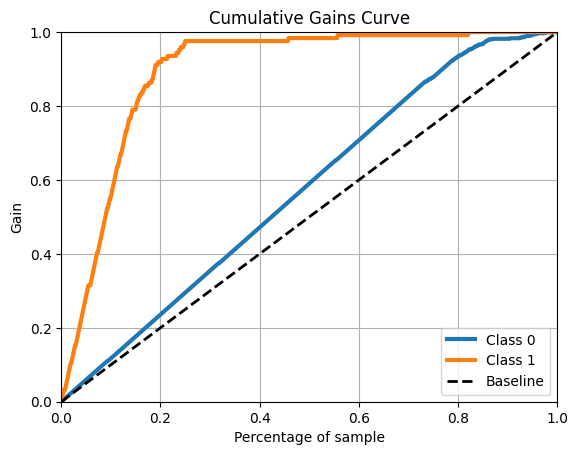

Analysis: 80% of first 105  instances rank-ordered by propensity are positive actuals in test dataset of size  788
Percentage of rank-ordered data to take as leads:  13.3248730964467
LEADS:



,Actual,Predicted,Propensity
0,1,1,1.0
1,1,1,1.0
2,1,1,1.0
3,1,1,1.0
4,1,1,1.0
...,...,...,...
101,1,1,1.0
102,1,1,0.8
103,1,1,0.8
104,0,1,0.8


In [40]:
# Rank order propsensities & display the first n records of the test dataset for which 80% are actual positives.
# Report the value of n as a percentage of the size of the test dataset

# First, compute the propensitiies of iunstances in the test dataset
clf_propensities = pd.DataFrame(clf.predict_proba(X_test_std))

# Create a dataframe showing actuals, predicted, and propensities
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, clf_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

# Sort the instances in results by propsensity
results.sort_values(by=['Propensity'], inplace=True, ascending=False)
results.reset_index(drop = True , inplace = True)

# Plot gains chart
skplt.metrics.plot_cumulative_gain(y_test, clf_propensities)
plt.show()

# Find the top-rated instances in results such that the actual positive label for 'Converted' of those instances is greater than or equal to 80%
# We will assume the first lead has a positive actual
index = 2
n = 1
fraction = 1
while ((index < len(results)) & (fraction >= 0.8)):
  if results.loc[index,'Actual'] == 1:
    n=n+1
  fraction = n/index
  index = index + 1

print('Analysis: 80% of first',n,' instances rank-ordered by propensity are positive actuals in test dataset of size ',len(results))
print('Percentage of rank-ordered data to take as leads: ',100*n/len(results))
print('LEADS:\n')
results.loc[:n]

In [41]:
from sklearn.metrics import roc_auc_score

def delta_from_balancing_predict(clf, X_test_std, delta=0.1):
    probas = clf.predict_proba(X_test_std)
    positive_probs = probas[:, 1]
    adjusted_predictions = (positive_probs > (0.5 + delta)).astype(int)
    return adjusted_predictions

# Evaluate the performance with delta from balancing
mean_accuracy_delta = 0.0
mean_balanced_accuracy_delta = 0.0
mean_auc_delta = 0.0

for fold, (train_index, test_index) in enumerate(kf.split(X,y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
    stdsc = StandardScaler()
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
    X_test_std = stdsc.transform(X_test)
    clf.fit(X_train_SMOTE_std, y_train_SMOTE)
    y_pred = delta_from_balancing_predict(clf, X_test_std, delta=0.1)  # Adjust delta as needed
    mean_accuracy_delta += clf.score(X_test_std, y_test)
    mean_balanced_accuracy_delta += balanced_accuracy_score(y_test, y_pred)
    mean_auc_delta += roc_auc_score(y_test, y_pred)

mean_accuracy_delta /= no_folds
mean_balanced_accuracy_delta /= no_folds
mean_auc_delta /= no_folds

print("Performance with Delta from Balancing:")
print('Average accuracy: %.3f, Average balanced accuracy: %.3f, Average AUC: %.3f\n\n' % (mean_accuracy_delta, mean_balanced_accuracy_delta, mean_auc_delta))


Performance with Delta from Balancing:
Average accuracy: 0.937, Average balanced accuracy: 0.905, Average AUC: 0.905




# Second Best Model: MLP

We are showing MLP as well because it produced very similar results to KNN. MLP did take a very long time to load.

In [ ]:
model = imbpipeline([
        ('sample', SMOTE()),
        ('std', StandardScaler()),
        ('clf', MLPClassifier())])

param_grid = {
    'clf__hidden_layer_sizes': [(50,50), (100,)],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__max_iter': [200,400,600],
    'clf__learning_rate_init': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, scoring = 'roc_auc')
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=54321, stratify=y)

In [ ]:
# SMOTE (oversampling)
# Data is unbalanced

import imblearn
print("imblearn version: ", imblearn.__version__)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12346)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

print("Shape before SMOTE: ", X_train.shape, y_train.shape, "\n")
print("Shape after SMOTE: ", X_train_SMOTE.shape, y_train_SMOTE.shape, "\n")

In [ ]:
# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
X_test_std = stdsc.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

# Initialize MLPClassifier with best parameters from grid search or default parameters
mlp = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0001, max_iter=400, learning_rate_init=0.001)

# Fit MLP model on SMOTE-resampled and standardized training data
mlp.fit(X_train_SMOTE_std, y_train_SMOTE)

# Predict test data labels
y_pred = mlp.predict(X_test_std)

# Evaluate performance using ROC AUC and accuracy
auc = roc_auc_score(y_test, y_pred)
accuracy = mlp.score(X_test_std, y_test)

# Print evaluation metrics
print(f'AUC: {auc}')
print(f'Accuracy: {accuracy}')

In [ ]:
# Reporting
print(confusion_matrix(y_test, y_pred))
print("Accuracy = ",accuracy_score(y_test, y_pred))
print("Recall = ",recall_score(y_test, y_pred))

In [ ]:
# Rank order propsensities & display the first n records of the test dataset for which 80% are actual positives.
# Report the value of n as a percentage of the size of the test dataset

# First, compute the propensitiies of iunstances in the test dataset
clf_propensities = pd.DataFrame(clf.predict_proba(X_test_std))

# Create a dataframe showing actuals, predicted, and propensities
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, clf_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

# Sort the instances in results by propsensity
results.sort_values(by=['Propensity'], inplace=True, ascending=False)
results.reset_index(drop = True , inplace = True)

# Plot gains chart
skplt.metrics.plot_cumulative_gain(y_test, clf_propensities)
plt.show()

# Find the top-rated instances in results such that the actual positive label for 'Converted' of those instances is greater than or equal to 80%
# We will assume the first lead has a positive actual
index = 2
n = 1
fraction = 1
while ((index < len(results)) & (fraction >= 0.8)):
  if results.loc[index,'Actual'] == 1:
    n=n+1
  fraction = n/index
  index = index + 1

print('Analysis: 80% of first',n,' instances rank-ordered by propensity are positive actuals in test dataset of size ',len(results))
print('Percentage of rank-ordered data to take as leads: ',100*n/len(results))
print('LEADS:\n')
results.loc[:n]

In [ ]:
from sklearn.metrics import roc_auc_score

def delta_from_balancing_predict(clf, X_test_std, delta=0.1):
    probas = clf.predict_proba(X_test_std)
    positive_probs = probas[:, 1]
    adjusted_predictions = (positive_probs > (0.5 + delta)).astype(int)
    return adjusted_predictions

# Evaluate the performance with delta from balancing
mean_accuracy_delta = 0.0
mean_balanced_accuracy_delta = 0.0
mean_auc_delta = 0.0

for fold, (train_index, test_index) in enumerate(kf.split(X,y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
    stdsc = StandardScaler()
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
    X_test_std = stdsc.transform(X_test)
    clf.fit(X_train_SMOTE_std, y_train_SMOTE)
    y_pred = delta_from_balancing_predict(clf, X_test_std, delta=0.1)  # Adjust delta as needed
    mean_accuracy_delta += clf.score(X_test_std, y_test)
    mean_balanced_accuracy_delta += balanced_accuracy_score(y_test, y_pred)
    mean_auc_delta += roc_auc_score(y_test, y_pred)

mean_accuracy_delta /= no_folds
mean_balanced_accuracy_delta /= no_folds
mean_auc_delta /= no_folds

print("Performance with Delta from Balancing:")
print('Average accuracy: %.3f, Average balanced accuracy: %.3f, Average AUC: %.3f\n\n' % (mean_accuracy_delta, mean_balanced_accuracy_delta, mean_auc_delta))

# Leaderboard of All Models

In [43]:
import pandas as pd

# Initialize an empty list to store results
results = []
# Evaluate the performance with Cost Sensitivity for each classifier
for name, clf in zip(names, classifiers):
    mean_accuracy_cost_sensitivity = 0.0
    mean_balanced_accuracy_cost_sensitivity = 0.0

    for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        sm = SMOTE()
        X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
        stdsc = StandardScaler()
        X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
        X_test_std = stdsc.transform(X_test)
        clf.fit(X_train_SMOTE_std, y_train_SMOTE)
        y_pred = clf.predict(X_test_std)
        mean_accuracy_cost_sensitivity += clf.score(X_test_std, y_test)
        mean_balanced_accuracy_cost_sensitivity += balanced_accuracy_score(y_test, y_pred)

    mean_accuracy_cost_sensitivity /= no_folds
    mean_balanced_accuracy_cost_sensitivity /= no_folds
    # Print and store results
    print('Classifier:', name)
    print('Average accuracy:', mean_accuracy_cost_sensitivity)
    print('Average balanced accuracy:', mean_balanced_accuracy_cost_sensitivity)
    print()

    # Append results to the list
    results.append({'Classifier': name,
                    'Average Accuracy': mean_accuracy_cost_sensitivity,
                    'Average Balanced Accuracy': mean_balanced_accuracy_cost_sensitivity})

# Create DataFrame from the list of results
results_df = pd.DataFrame(results)
print(results_df)

Classifier: Perceptron
Average accuracy: 0.7457142857142858
Average balanced accuracy: 0.7283513097072419

Classifier: Logistic Regression
Average accuracy: 0.8244444444444443
Average balanced accuracy: 0.8481938024310904

Classifier: SVM (RBF kernel)
Average accuracy: 0.7749206349206349
Average balanced accuracy: 0.8623694572847116

Classifier: Decision Tree
Average accuracy: 0.586984126984127
Average balanced accuracy: 0.7508816983393254

Classifier: Naive Bayes
Average accuracy: 0.6847619047619047
Average balanced accuracy: 0.7809450436569081

Classifier: k Nearest Neighbors
Average accuracy: 0.9384126984126985
Average balanced accuracy: 0.9215545283341893

Classifier: MLP
Average accuracy: 0.9333333333333333
Average balanced accuracy: 0.939085772984078

Classifier: Random Forest
Average accuracy: 0.5888888888888889
Average balanced accuracy: 0.7552987502140045

Classifier: XG Boost
Average accuracy: 0.7901587301587301
Average balanced accuracy: 0.8689436740284198

            Class

# Conclusion

Several models with AUC above 91%. A KNN model was developed with AUC mean of 0.925, mean recall of 0.919, and mean accuracy of 0.938. MLP model provided similar performance.

We did not test the possibility that outliers (that we deleted) may end up actually helping our model. We compared the result with and without balancing, and it didn’t really effect the accuracy.

KNN and MLP exhibit strong performance with high accuracy and balanced accuracy, effectively handling class imbalance. Decision Tree and Random Forest show lower performance, indicating challenges with imbalance. SVM and XG Boost's performance could benefit from hyperparameter tuning. Overall, KNN and MLP are recommended for robust classification. There's a very small difference between runing these two models when they are not balanced compared to when they are balanced.
